# Heuristic based push-up counter

This file uses a signal processing approach instead of deep learning.
The key insight is that during a push-up, the shoulder elbow angle oscillates
periodically. We detect these oscillations using peak detection.

This serves as a baseline for comparison with deep learning approaches.


In [1]:
import pandas as pd

from neural_net.data_loader import VideoDataset

video_dir = './video-data'

In [2]:
from feature_engineering.constants import TARGET_FPS
from feature_engineering.heuristic_pushup_counter import (
    HeuristicPushupCounter,
    CountPushupResults,
)
from feature_engineering.heuristic_evaluation import (
    evaluate_on_dataset,
    grid_search_parameters,
)
from feature_engineering.resampling_utils import resampled_index_to_original_frame

# Evaluate the Heuristic Model

Since this is a heuristic approach (not learned), there is no "training" phase.
Instead, we evaluate the signal processing based counter on our data and tune 
the hyperparameters using grid search.

In [3]:
def run_heuristic_evaluation(
    video_dir: str = './video-data',
):
    """Evaluate the heuristic push-up counter on the dataset.
    
    Args:
        video_dir: Path to the video data directory.
    """
    print("Running grid search for optimal parameters...")
    
    # Use training set for parameter tuning and get train/val loaders
    search_results = grid_search_parameters(
        video_dir=video_dir,
        val_split=0.2,
        smoothing_windows=[11, 15, 21, 31],
        min_prominences=[0.03, 0.05, 0.08, 0.11],
        min_distances=[5, 10, 15, 20, 30],
        median_filter_sizes=[3, 5, 7],
    )
    
    # Create counter with best parameters from grid search
    counter = HeuristicPushupCounter(search_results.best_params)
    
    # Evaluate on training set
    print("\nTraining Set Results:")
    train_metrics = evaluate_on_dataset(search_results.train_loader, counter)
    
    train_df = pd.DataFrame([{
        'MAE': train_metrics['mae'],
        'Accuracy (%)': train_metrics['accuracy'] * 100,
        'Within-1 Acc (%)': train_metrics['within_1_accuracy'] * 100
    }])
    print(train_df.to_string(index=False))
    
    # Evaluate on validation set using the val_loader from grid search
    print("\nValidation Set Results:")
    val_metrics = evaluate_on_dataset(search_results.val_loader, counter)
    
    val_df = pd.DataFrame([{
        'MAE': val_metrics['mae'],
        'Accuracy (%)': val_metrics['accuracy'] * 100,
        'Within-1 Acc (%)': val_metrics['within_1_accuracy'] * 100
    }])
    print(val_df.to_string(index=False))
    
    return counter, train_metrics, val_metrics

In [4]:
# Run the evaluation
counter, train_metrics, val_metrics = run_heuristic_evaluation(
    video_dir='./video-data',
)

Running grid search for optimal parameters...
Train: 62 videos, Val: 15 videos


Grid Search:   0%|          | 0/240 [00:00<?, ?it/s]


Grid Search Complete.
Best MAE: 0.0323
Best Parameters: CounterParameters(smoothing_window=21, poly_order=3, min_prominence=0.11, min_distance=5, median_filter_size=3)


Training Set Results:
     MAE  Accuracy (%)  Within-1 Acc (%)
0.032258     96.774194             100.0

Validation Set Results:
 MAE  Accuracy (%)  Within-1 Acc (%)
 0.0         100.0             100.0


Visualize the signal processing on sample videos to understand how the heuristic works.

Video: 2_sadfasjldkfjaseifj.mp4
  Source FPS: 29.77, Target FPS: 30.0, Ratio: 0.99
  Total original frames: 159, Resampled sequence length: 160


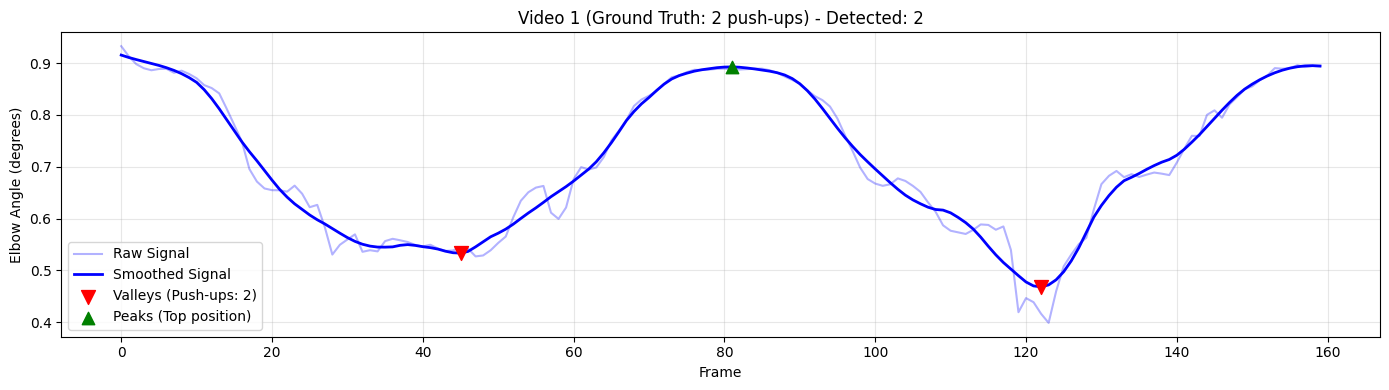

Valleys (Bottom positions) - 2 detected:


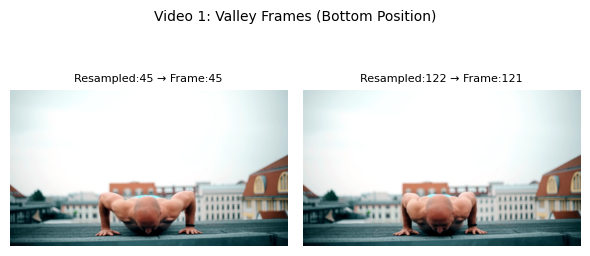

Peaks (Top positions) - 1 detected:


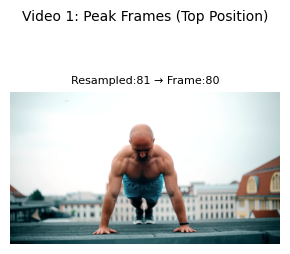

Video: 2_sdafkjaslkclaksdjkas.mp4
  Source FPS: 23.23, Target FPS: 30.0, Ratio: 0.77
  Total original frames: 121, Resampled sequence length: 108


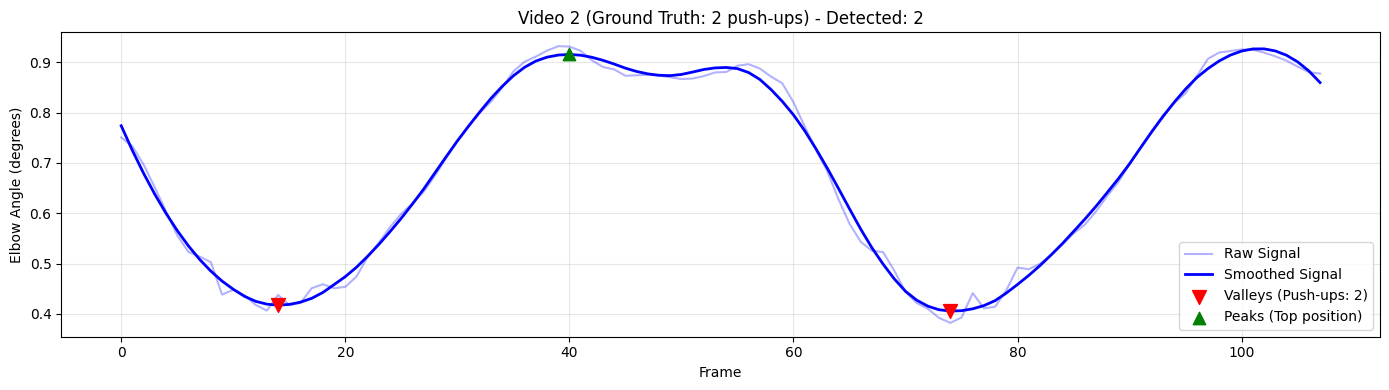

Valleys (Bottom positions) - 2 detected:


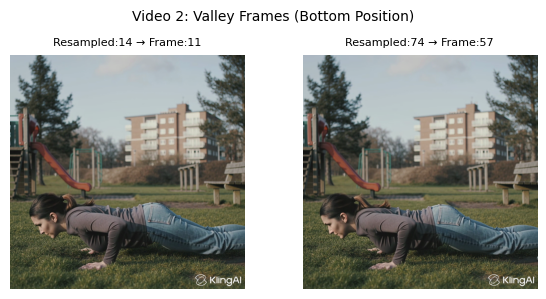

Peaks (Top positions) - 1 detected:


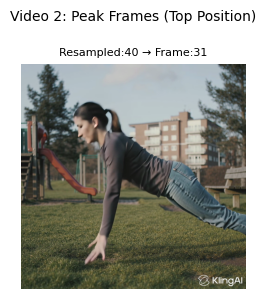

Video: 4_kling_20251206_Text_to_Video_Generate_a_28_0.mp4
  Source FPS: 24.00, Target FPS: 30.0, Ratio: 0.80
  Total original frames: 241, Resampled sequence length: 301


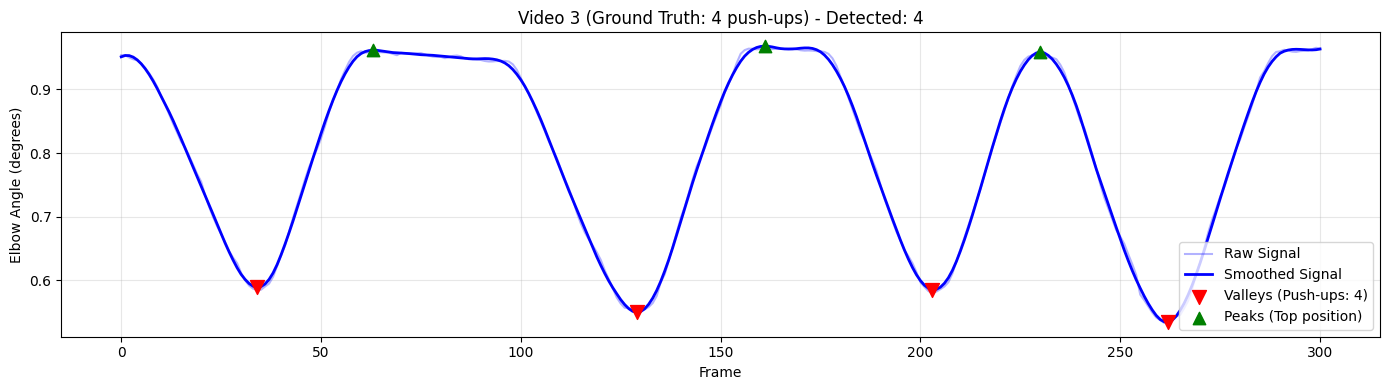

Valleys (Bottom positions) - 4 detected:


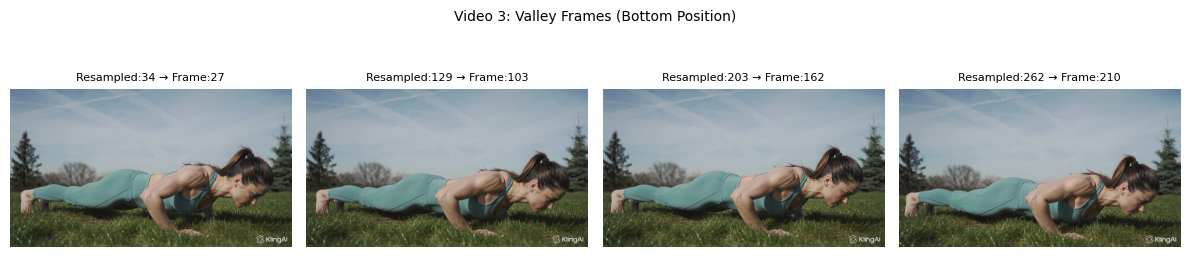

Peaks (Top positions) - 3 detected:


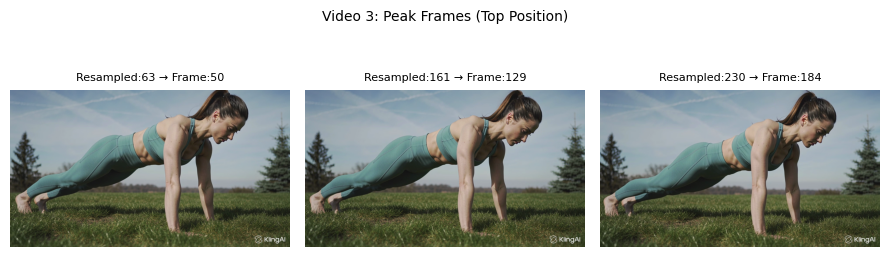

Visualization complete.


In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


def plot_pushup_results(
    pushup_results: CountPushupResults,
    title: str = "Push-up Detection",
    ax: plt.Axes = None,
    save_path: str = None
) -> plt.Figure:
    """Plot the signal with detected peaks for visualization.
    
    Args:
        pushup_results: CountPushupResults object from count_pushups.
        title: Plot title.
        ax: Optional matplotlib axes to plot on.
        save_path: If provided, save the figure to this path.
        
    Returns:
        The matplotlib Figure object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    else:
        fig = ax.get_figure()
    
    # Extract signals from landmarks using signal_index
    raw_signal = pushup_results.raw_angle_sequence[:, pushup_results.signal_index]
    smoothed_signal = pushup_results.smoothed_angle_sequence[:, pushup_results.signal_index]
    
    frames = np.arange(len(raw_signal))
    
    # Plot raw signal
    ax.plot(frames, raw_signal, 'b-', alpha=0.3, label='Raw Signal')
    
    # Plot smoothed signal
    ax.plot(frames, smoothed_signal, 'b-', linewidth=2, label='Smoothed Signal')
    
    # Mark valleys (bottom positions = push-ups)
    if len(pushup_results.valleys) > 0:
        ax.scatter(
            pushup_results.valleys,
            smoothed_signal[pushup_results.valleys],
            c='red', s=100, marker='v', zorder=5,
            label=f"Valleys (Push-ups: {pushup_results.count})"
        )
    
    # Mark peaks (top positions)
    if len(pushup_results.peaks) > 0:
        ax.scatter(
            pushup_results.peaks,
            smoothed_signal[pushup_results.peaks],
            c='green', s=80, marker='^', zorder=5,
            label='Peaks (Top position)'
        )
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Elbow Angle (degrees)')
    ax.set_title(f"{title} - Detected: {pushup_results.count}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        
    return fig


def get_video_frame(video_path: str, frame_idx: int):
    """Extract a single frame from a video file.
    
    Args:
        video_path: Path to the video file.
        frame_idx: Index of the frame to extract.
        
    Returns:
        RGB numpy array of the frame, or None if extraction failed.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        # Convert BGR to RGB for matplotlib
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return None


# Visualize detection on a few sample videos
def visualize_sample_detections(video_dir: str = './video-data', num_samples: int = 3):
    """Visualize the push-up detection on sample videos.
    
    Shows the signal plot with detected peaks/valleys and displays the actual
    video frames at those positions to verify the detection accuracy.
    
    Note: The angle sequences are resampled to 30 FPS during feature extraction.
    Frame indices are mapped back to original video frames for visualization.
    """
    import os
    
    dataset = VideoDataset(video_dir, feature_processor=lambda features : (features.angle_sequence,))
    
    for i in range(min(num_samples, len(dataset))):
        landmarks, label = dataset[i]
        video_filename = dataset.video_files[i]
        video_path = os.path.join(video_dir, video_filename)
        
        # Get the original video's FPS for frame mapping
        cap = cv2.VideoCapture(video_path)
        source_fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        
        if source_fps <= 0:
            source_fps = 30.0
        
        fps_ratio = source_fps / TARGET_FPS
        
        # Get debug info including peak/valley frame indices (in resampled space)
        pushup_results = counter.count_pushups(landmarks)
        valleys = pushup_results.valleys
        peaks = pushup_results.peaks
        
        print(f"Video: {video_filename}")
        print(f"  Source FPS: {source_fps:.2f}, Target FPS: {TARGET_FPS}, Ratio: {fps_ratio:.2f}")
        print(f"  Total original frames: {total_frames}, Resampled sequence length: {len(landmarks)}")
        
        # Create the signal plot
        fig_signal, ax_signal = plt.subplots(figsize=(14, 4))
        plot_pushup_results(
            pushup_results, 
            title=f"Video {i+1} (Ground Truth: {label} push-ups)",
            ax=ax_signal
        )
        plt.tight_layout()
        plt.show()
        
        # Display frames at valleys (bottom positions / push-ups)
        if len(valleys) > 0:
            print(f"Valleys (Bottom positions) - {len(valleys)} detected:")
            num_valleys = len(valleys)
            cols = min(5, num_valleys)  # Max 5 per row
            rows = (num_valleys + cols - 1) // cols
            
            fig_valleys, axes_valleys = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows), squeeze=False)
            
            for j, resampled_idx in enumerate(valleys):
                row, col = divmod(j, cols)
                ax = axes_valleys[row, col]
                original_frame_idx = resampled_index_to_original_frame(resampled_idx, source_fps)
                
                frame = get_video_frame(video_path, original_frame_idx)
                if frame is not None:
                    ax.imshow(frame)
                    ax.set_title(f"Resampled:{resampled_idx} → Frame:{original_frame_idx}", fontsize=8)
                ax.axis('off')
            
            # Hide empty axes
            for j in range(num_valleys, rows * cols):
                row, col = divmod(j, cols)
                axes_valleys[row, col].axis('off')
            
            plt.suptitle(f"Video {i+1}: Valley Frames (Bottom Position)", fontsize=10)
            plt.tight_layout()
            plt.show()
        
        # Display frames at peaks (top positions)
        if len(peaks) > 0:
            print(f"Peaks (Top positions) - {len(peaks)} detected:")
            num_peaks = len(peaks)
            cols = min(5, num_peaks)
            rows = (num_peaks + cols - 1) // cols
            
            fig_peaks, axes_peaks = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows), squeeze=False)
            
            for j, resampled_idx in enumerate(peaks):
                row, col = divmod(j, cols)
                ax = axes_peaks[row, col]
                original_frame_idx = resampled_index_to_original_frame(resampled_idx, source_fps)
                
                frame = get_video_frame(video_path, original_frame_idx)
                if frame is not None:
                    ax.imshow(frame)
                    ax.set_title(f"Resampled:{resampled_idx} → Frame:{original_frame_idx}", fontsize=8)
                ax.axis('off')
            
            # Hide empty axes
            for j in range(num_peaks, rows * cols):
                row, col = divmod(j, cols)
                axes_peaks[row, col].axis('off')
            
            plt.suptitle(f"Video {i+1}: Peak Frames (Top Position)", fontsize=10)
            plt.tight_layout()
            plt.show()
        
        print(f"{'='*60}")
    
    print("Visualization complete.")

visualize_sample_detections()